In [ ]:
!pip install piml

# Data Pipeline

In [ ]:
from piml import Experiment
exp = Experiment()
exp.data_loader(data='CaliforniaHousing_trim2')

(CVXPY) Nov 04 01:52:08 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 04 01:52:08 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [ ]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [ ]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

# Model Pipeline

In [ ]:
from xgboost import XGBRegressor
XGB = XGBRegressor(max_depth=5, n_estimators=500)
exp.model_train(model=XGB, name='XGB5')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
from sklearn.neural_network import MLPRegressor
DNN = MLPRegressor(hidden_layer_sizes=[40] * 4, activation="relu", random_state=0)
exp.model_train(model=DNN, name='ReLUDNN')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

# Model Diagnostics

## Reliability Testing

- Quantify prediction uncertainty by conformalized residual quantile regression (w/ guaranteed coverage)
- Feature identification in relation to prediction uncerntainty
- Unreliable region detection by slicing the quantified bandwidth


In [ ]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [ ]:
exp.model_diagnose(model="ReLUDNN", show="reliability_table", alpha=0.1)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Empirical Coverage,Average Bandwidth
0,0.896426,0.307637


## Feature Identification

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

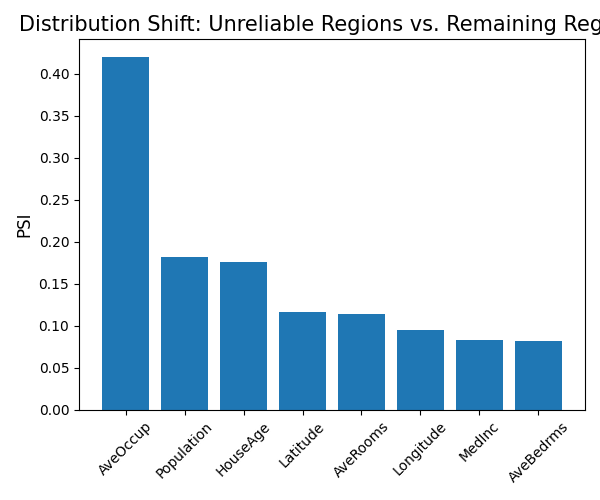

In [ ]:
# Measuring distribution shift between unreliable and reliable samples
exp.model_diagnose(model="ReLUDNN",
          show="reliability_distance", alpha=0.1,
          threshold=1.1, distance_metric="PSI",
          figsize=(6, 5))

In [30]:
# Auxiliary modeling for feature identification in relation to prediction uncertainty
import numpy as np
from matplotlib import pyplot as plt

from piml.models import XGB2Regressor
from piml.diagnoser.reliability import Reliability


def pred_uq_auxi_fi(model_name, alpha=0.1, max_depth=2, max_trees=200):

  # Fit reliability diagnoser
  all_x, all_y, _ = exp.get_data()
  data_dict = {'x': all_x,
          'y': all_y,
          'train_idx': exp.get_model(model_name).dataset.train_idx,
          'test_idx': exp.get_model(model_name).dataset.test_idx,
          'feature_names': exp.get_feature_names(),
          'feature_types': exp.get_feature_types()}

  reliability = Reliability(estimator=exp.get_model(model_name).estimator,
                 alpha=alpha, random_state=0)
  reliability.fit(**data_dict)
  bandwidth = reliability.method.width.reshape(-1, 1)

  # Fit an auxiliary model on bandwidth
  auxi_model = XGB2Regressor(max_depth=max_depth, n_estimators=max_trees)
  auxi_model.fit(reliability.test_x, bandwidth)

  # Get FI of auxi model
  unp = auxi_model.parse_model()
  unp.global_interpret(reliability.test_x)
  res = unp.feature_importance_
  order = np.argsort(unp.feature_importance_)

  # Plot Feature importance bar plot
  plt.figure(figsize=(6, 5))
  plt.barh(np.array(data_dict['feature_names'])[order], unp.feature_importance_[order])
  plt.xlabel("PFI")
  plt.tight_layout()
  plt.show()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

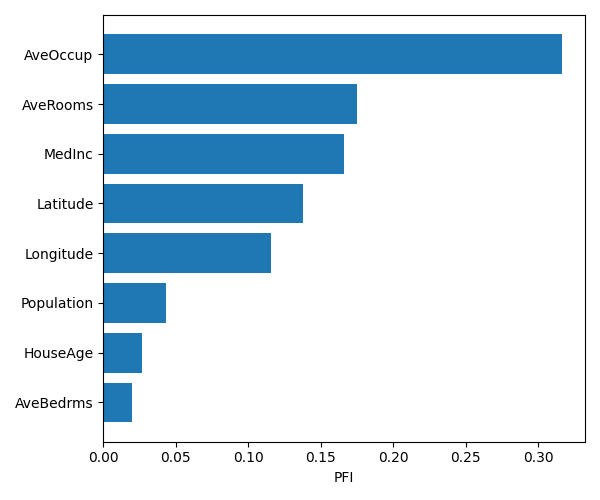

In [32]:
pred_uq_auxi_fi(model_name="ReLUDNN", alpha=0.1, max_depth=1, max_trees=200)

## Unreliable Region Detection

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

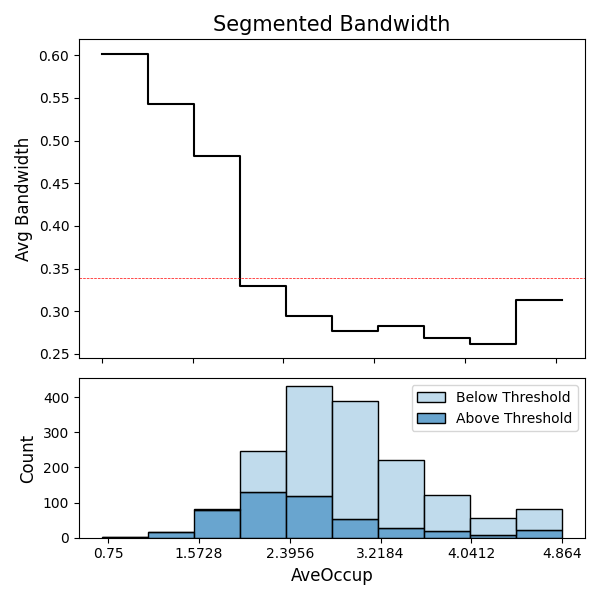

In [ ]:
# Detect uncertain region
exp.model_diagnose(model="ReLUDNN", show="reliability_marginal",
          alpha=0.1, threshold=1.1,
          show_feature="AveOccup", bins=10,
          original_scale=True, figsize=(6, 6))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

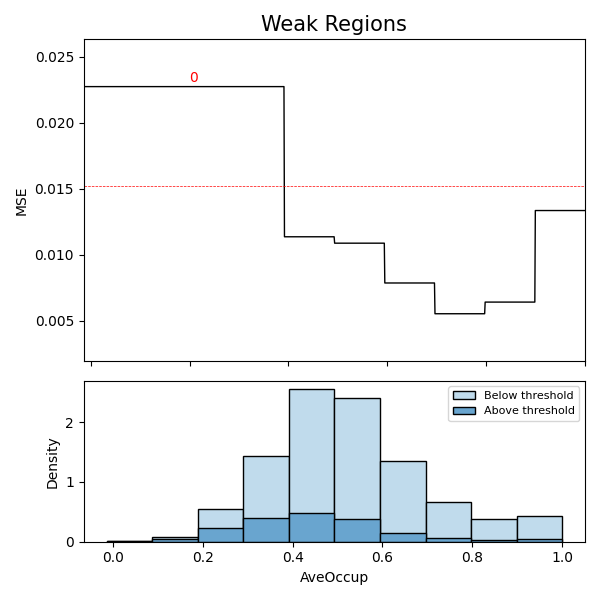

In [ ]:
exp.model_diagnose(model="ReLUDNN", show="weakspot", metric="MSE",
          slice_method="histogram", slice_features=["AveOccup"],
          threshold=1.2, min_samples=20, use_test=True, figsize=(6, 6))

# Prediction UQ Benchmarking

In [ ]:
# CaliforniaHousing (Regression Case)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

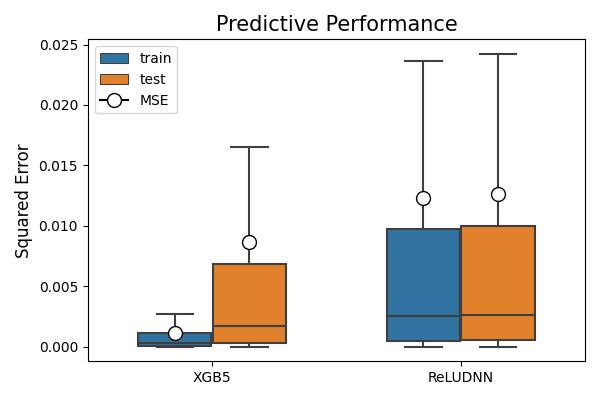

In [ ]:
exp.model_compare(models=["XGB5", "ReLUDNN"], show="accuracy_plot", metric="MSE", figsize=(6, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

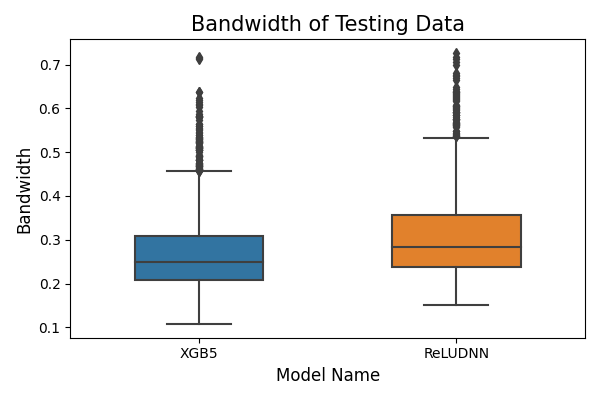

In [ ]:
exp.model_compare(models=["XGB5", "ReLUDNN"], show="reliability_bandwidth", figsize=(6, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

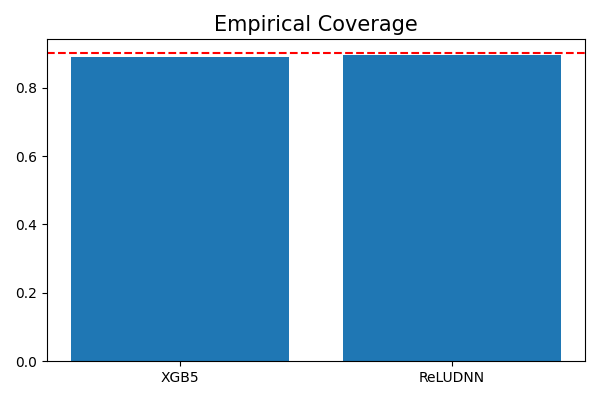

In [ ]:
exp.model_compare(models=["XGB5", "ReLUDNN"], show="reliability_coverage", figsize=(6, 4))